In [122]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [123]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        
        self.tanh = nn.Tanh()
        
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l1.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l1.weight)

        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l2.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l2.weight)

        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l3.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l3.weight)

        self.l4 = nn.Linear(hidden_size, output_size)
        self.l4.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l4.weight)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        return out

In [124]:
K = 40
r = 0.05
sigma = 0.15
T = [0.0, 1.0]
S = [0, 160]
t_sample_size = 101
S_sample_size = 101

In [125]:
pinn = NN(2, 16, 1)
pinn.to(device)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.01)

t_samples = torch.linspace(T[0], T[1], t_sample_size)
S_samples = torch.linspace(S[0], S[1], S_sample_size)

# Boundary: C(0,t) = 0
boundary1 = torch.stack((torch.full((t_sample_size,), S[0]), t_samples), dim=1).requires_grad_(True)
# Bourdary: C(S->inf,t) = S-Ke^-r(T-t)
boundary2 = torch.stack((torch.full((t_sample_size,), S[1]), t_samples), dim=1).requires_grad_(True)
# Boundary: C(S,T) = max(S-K, 0)
boundary3 = torch.stack((S_samples, torch.full((S_sample_size,), T[1])), dim=1).requires_grad_(True)

# Mesh (S,t)
mesh = torch.cartesian_prod(S_samples, t_samples).requires_grad_(True)

losses = []

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    
    # Boundary losses
    u = pinn(boundary1)
    loss_boundary1 = torch.squeeze(u).pow(2)
    
    u = pinn(boundary2)
    S_inf = S[1] - K * torch.exp(-r * (T[1] - t_samples))
    loss_boundary2 = (torch.squeeze(u) - S_inf).pow(2)
    
    u = pinn(boundary3)
    loss_boundary3 = (torch.squeeze(u) - torch.fmax(S_samples-K, torch.tensor(0))).pow(2)
    
    boudary_loss = loss_boundary1 + loss_boundary2 + loss_boundary3
    
    # PDE loss
    u = pinn(mesh)
    du = torch.autograd.grad(u, mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    dudt, duds = du[:, 0], du[:, 1]
    d2uds2 = torch.autograd.grad(duds, mesh, grad_outputs=torch.ones_like(duds), create_graph=True)[0][:, 1]
    
    S1 = mesh[:, 1]
    pde_loss = (dudt + 0.5*sigma**2*S1**2*d2uds2 + r*S1*duds - r*u).pow(2)

    loss = pde_loss.mean() + boudary_loss.mean()
    losses.append(loss.item())

    loss.backward()

    optimizer.step()

In [126]:
plt.plot(losses)
plt.show()

In [129]:
s_grid = np.linspace(S[0], S[1], 101) #np.linspace(0, 160, 101)
t_grid = np.linspace(T[0], T[1], 101)#np.linspace(0, 1, 101)
s_grid_mesh, t_grid_mesh = np.meshgrid(s_grid, t_grid)

c = pinn(mesh).detach().cpu().numpy()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', elev=30, azim=15)
# Plot the surface
surf = ax.plot_surface(s_grid_mesh, t_grid_mesh, c, cmap='viridis', edgecolor='none')
# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=10)
# Labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('u')

# ax.set_xlim(0, 160)  # Set s range
# ax.set_ylim(0, 1)    # Set t range

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_78180/3717881560.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  d1 = (np.log(underlying_price / strike_price) + time_to_expire * (interest_rate + (volatility ** 2 / 2))) / (volatility * np.sqrt(time_to_expire))
/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_78180/3717881560.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  d2 = d1 - (volatility * np.sqrt(time_to_expire))
/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_78180/3717881560.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  call = underlying_price * norm.cdf(d1, 0, 1) - strike_price * np.exp(-interest_rate*time_to_expire) * norm.cdf(d2, 0, 1)
/var/folders/fc/1h8c1q2

Iter: 0, Loss: 2.163e+04
Iter: 100, Loss: 1.371e+04
Iter: 200, Loss: 9.418e+03
Iter: 300, Loss: 6.409e+03
Iter: 400, Loss: 4.319e+03
Iter: 500, Loss: 2.883e+03
Iter: 600, Loss: 1.887e+03
Iter: 700, Loss: 1.233e+03
Iter: 800, Loss: 7.827e+02
Iter: 900, Loss: 5.096e+02


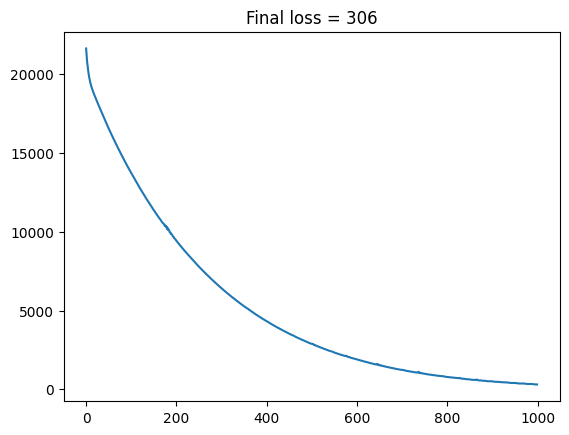

In [130]:
mu = 0.02
n = 100
dt = 0.1
x0 = 100

sigma = np.full(10, 0.1)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.plot([np.average(av) for av in x], 'k--')
plt.show()

In [131]:
df = pd.read_csv('aapl_eod_202001.csv', sep=r'\s*,\s*', engine='python')
# plt.plot(df.sort_values(by='[QUOTE_UNIXTIME]')['[QUOTE_UNIXTIME]'], df.sort_values(by='[QUOTE_UNIXTIME]')['[UNDERLYING_LAST]'])
dat = df[df['[QUOTE_DATE]'] == '2020-01-02']
plt.hist(dat['[UNDERLYING_LAST]'])

/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_78180/3717881560.py:3: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(underlying_price / strike_price) + time_to_expire * (interest_rate + (volatility ** 2 / 2))) / (volatility * np.sqrt(time_to_expire))
/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_78180/3717881560.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying_price / strike_price) + time_to_expire * (interest_rate + (volatility ** 2 / 2))) / (volatility * np.sqrt(time_to_expire))
/var/folders/fc/1h8c1q2j0l546qfdym_l1xg00000gn/T/ipykernel_78180/3717881560.py:3: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(underlying_price / strike_price) + time_to_expire * (interest_rate + (volatility ** 2 / 2))) / (volatility * np.sqrt(time_to_expire))


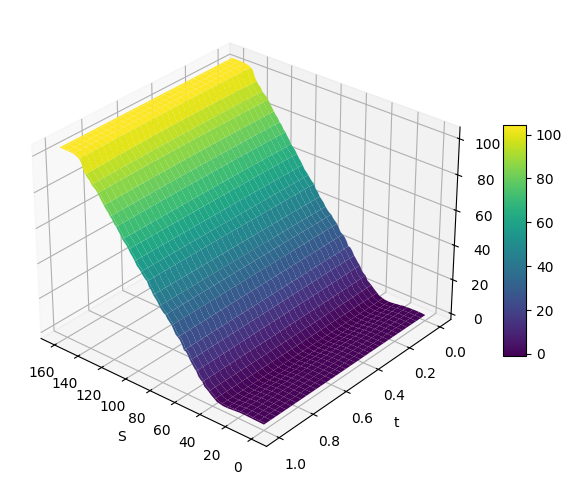

ValueError: Argument Z must be 2-dimensional.

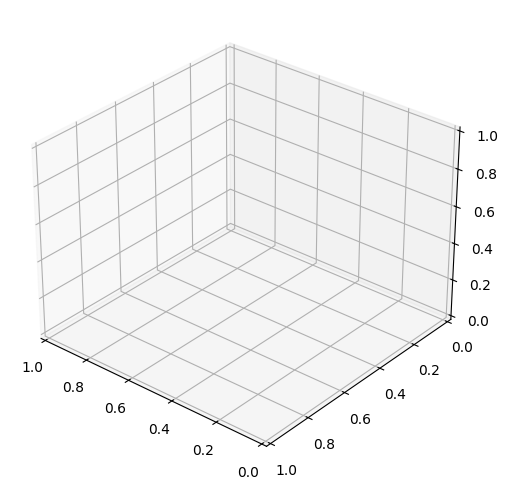

In [132]:
print(0)